# Low-Level Analysis
Jana Bruses | janabruses@pitt.edu | University of Pittsburgh | Apr. 3rd - Apr. 21st

First analysis notebook of a series of two.\
Third notebook of the project, after [Data-Parsing-Exploratory-Analysis-2](https://github.com/Data-Science-for-Linguists-2025/Linguistic-Markers-Catalan-Substitution/blob/main/Data-Parsing-Exploratory-Analysis-2.ipynb).

This analysis aims to quantify the linguistic markers of Catalan language substitution by measuring specific changes over time.\
The following exploration looks at lower-level linguistic symptoms (morphological, syntactic, lexical, and semantic).\
For higher-level/text characteristics that could indicate increasing convergence with Spanish check the notebook [Analysis-2-TextLevel](https://github.com/Data-Science-for-Linguists-2025/Linguistic-Markers-Catalan-Substitution/blob/main/Analysis-2-TextLevel.ipynb).\
The data colection and dataframe building process used for this analysis can be found in [Data-Parsing-Exploratory-Analysis-2](https://github.com/Data-Science-for-Linguists-2025/Linguistic-Markers-Catalan-Substitution/blob/main/Data-Parsing-Exploratory-Analysis-2.ipynb), that now will be loaded from their pickled form as our data.

Contents of this analysis notebook:\
**0** [Recap Data Analysis](#Quick-recap-analysis-to-refresh-our-memory)\
**1** [Loss of Word Classes](#1.-Loss-of-word-classes---pronoms-febles)\
**2** [Time/Space Lexicon](#2.-Time-and-space-lexicon-modification)\
**3** [Syntactic Restructuring](#3.-Syntactic-restructuring)\
**4** [Low-Level Analysis Conclusion and Findings](#4.-Low-Level-Analysis-Conclusion-and-Findings) 

In [142]:
# loading libraries
import pandas as pd
import re
import stanza
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.stats import spearmanr

In [143]:
# loading the pickled complete dataframe 
tokscomplete_df = pd.read_pickle("tokcomplete_df.pkl")

In [144]:
# keeping only the columns we are interested in
tokscomplete_df = tokscomplete_df[["Year", "Line_id", "Text", "Text_len", "toks", "Len_toks"]]

### Quick recap analysis of the data to refresh our memory

In [145]:
# quick recap data on the dataframe
print("There are", tokscomplete_df.shape, "pieces of text")
print("The total of tokens in the dataframe is:", tokscomplete_df["Len_toks"].sum())

There are (75480, 6) pieces of text
The total of tokens in the dataframe is: 3063943


In [146]:
tokscomplete_df.describe()

,Year,Text_len,Len_toks
count,75480.000000,75480.000000,75480.000000
mean,2008.832658,187.739043,40.592780
std,3.064608,611.358140,122.724208
min,1860.000000,0.000000,0.000000
25%,2008.000000,38.000000,9.000000
50%,2009.000000,95.000000,21.000000
75%,2010.000000,222.000000,48.000000
max,2022.000000,73881.000000,14727.000000


**Comment:**\
The total amount of data in tokens we are working with is about three million tokens.\
The oldest text we have data from is from 1860, while the most recent is from 2022.\
The distribution of the data leans more towards recent years as the mean date of pieces of text is 2008.

In [147]:
# some duplicates were found while working so I'll drop them now and again in other parts
# as unpickled frames were also created from the df with duplicates 
tokscomplete_df = tokscomplete_df.drop_duplicates(subset="Text", keep="first")

In [148]:
tokscomplete_df.shape

(64944, 6)

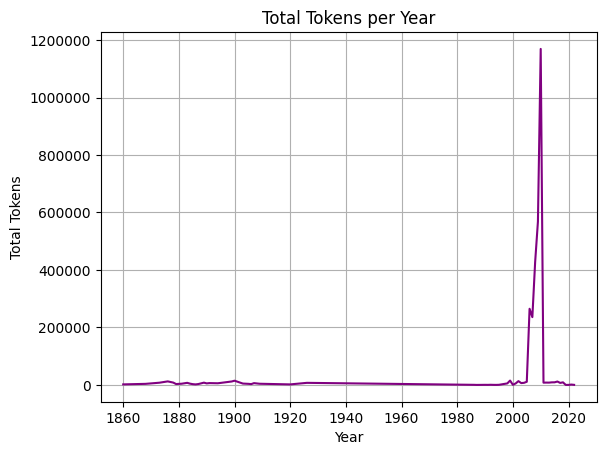

In [149]:
# taking a look at the uneven distribution of the data for clarification
toks_per_year = tokscomplete_df.groupby("Year")["Len_toks"].sum()
toks_per_year = toks_per_year.sort_index()

# plotting tokens per year with years on the x-axis
toks_per_year.plot(kind="line", color="purple")
plt.xlabel("Year")
plt.ylabel("Total Tokens")
plt.title("Total Tokens per Year")
plt.grid(True)
plt.gca().yaxis.set_major_formatter(lambda x, _: int(x))
plt.show()

**A note on the following analysis**\
Because of the difference in data sizes for each year, and in the distribution of our data, row counts would not be very valuable. To avoid this issue, all counts will be evaluated considering the size of the amount of tokens of the year they belong to.\
To do so we will work always considering the proportion of data this counts represent in the overall data amount for the respective year, as a percentage.

In [150]:
# making a proportion function 
# for reusability and consistency
def proportion(row, feature):
    '''
    takes in a row and the feature
    fetches the row's count for that feature
    divides the row count by the token length of that row
    multiplies the division result by a 100 to get a precentage
    returns the percentage 
    '''
    count_col = feature
    if row["Len_toks"] > 0:
        percent = (row[count_col] / row["Len_toks"]) * 100 
    else:
        percent = 0
    return percent

With this consideration in mind, and the function defined, we will now start the analysis:

## 1. Loss of word classes - pronoms febles

Following Dr. Junyent's idea that one of the key warnings of a language endangerement's is the loss of word classes we will conduct a frequency exploration of Pronoms Febles as our target word class. Specifically we will take a close look at the **"hi"** pronoun that can't be found in Spanish and might be dropped to copy Spanish's structures.\
"en" is another "pronom feble" not found in Spanish. However, as "en" is a word that has many other functions and would be harder to identify we will focus on "hi".\
The following examples and explanations on the pronoun "hi" have been guided by, taken and translated from [els-pronoms-son-vida](https://www.vilaweb.cat/noticies/els-pronoms-son-vida/), an article on the lead online Catalan's newspaper written by the Catalan philologist Jordi Badia i Pujol, who does an amazing job presenting "en" and "hi", cornerstones of Catalan, naming them "the life of Catalan."

(Badia, J. (2024, 26 de març). Els pronoms són vida. VilaWeb. https://www.vilaweb.cat/noticies/els-pronoms-son-vida/)

### Brief grammatical background for **"hi"**

It's a pronoun is used to replace complements starting with any preposition other than "de" (which would be replaced by "en")\
For example:\
Demà anem al pis. ---> Demà **hi** anem\
*We are going to the flat tomorrow ---> We are going "to it" tomorrow\
"hi" = al pis/*the flat*

Some examples of some of the most common situations in which this pronoun is being forgotten:
* *Sé que t’esperen a la piscina, però no **ø** pots anar -> [...], no **hi** pots anar
* Demà hi ha la festa, però jo **ø** no estaré -> [...], però jo no **hi** seré
* Sí que **ø** està, però ara no **ø** es pot posar -> Sí que **hi** és, però ara no **s’hi** pot posar
* Avui pot haver **ø** una desgràcia -> Avui pot **haver-hi** una desgràcia

Looking at these examples, we can see that what we need to scan the text for is:
- "hi"\
  when the clitic pronom feble is a proclitic
- "-hi"\
  when it is an enclitic

In [151]:
# creating a column with the lowercased token list 
tokscomplete_df["toks_low"] = tokscomplete_df["toks"].apply(lambda x: [w.lower() for w in x])

In [152]:
# creating a function to find pronom febles and their context 
def get_pf(tok_list, pf_target):
    '''
    takes in a token list and a pronom feble as target
    returns a list of 3 element tupples: 
    (preceding word, target pronom feble, following word)
    '''
    found = [(tok_list[tok_list.index(word)-1], word, tok_list[tok_list.index(word)+1]) 
             for word in tok_list if re.fullmatch(pf_target, word) and tok_list.index(word) < len(tok_list)-1]
    return set(found)

In [153]:
# finding the "hi" pronom feble
tokscomplete_df["hi"] = tokscomplete_df["toks_low"].apply(lambda x: get_pf(x, r"hi")) #proclitic
tokscomplete_df["-hi"] = tokscomplete_df["toks_low"].apply(lambda x: get_pf(x, r".*-hi")) #enclitic

In [154]:
# initially the idea was to also scan for "en" but due to its multiple functions, this section has been commented out
#tokscomplete_df["en"] = tokscomplete_df["toks_low"].apply(lambda x: get_pf(x, r"en"))
#tokscomplete_df["se'n"] = tokscomplete_df["toks_low"].apply(lambda x: get_pf(x, r"se'n"))
#tokscomplete_df["n'"] = tokscomplete_df["toks_low"].apply(lambda x: get_pf(x, r"n[’']"))
#tokscomplete_df["-ne"] = tokscomplete_df["toks_low"].apply(lambda x: get_pf(x, r".*-ne"))

In [155]:
# taking a look at the dataframe after these new columns
tokscomplete_df.head()

,Year,Line_id,Text,Text_len,toks,Len_toks,toks_low,hi,-hi
0,1926,Discurs llegit per... donar a conèxer la perso...,"L'home que per amor al estudi, impulsat per un...",37497,"[L', home, que, per, amor, al, estudi, ,, impu...",7267,"[l', home, que, per, amor, al, estudi, ,, impu...","{(n', hi, hagi)}",{}
1,1920,Parlament llegit en la festa inaugural de l'Or...,"Cantaires de la Garriga, Senyores i senyors:\n...",9253,"[Cantaires, de, la, Garriga, ,, Senyores, i, s...",1865,"[cantaires, de, la, garriga, ,, senyores, i, s...","{(m', hi, vaig)}",{}
2,1900,Discurs-pròlec,Discurs-prolec Llegit en la societat mèdic-far...,73881,"[Discurs-prolec, Llegit, en, la, societat, mèd...",14727,"[discurs-prolec, llegit, en, la, societat, mèd...","{(pròu, hi, gosaria)}",{}
3,1894,Discurs,"Senyors excelentissims, senyors:\n\nQuan rebí ...",29393,"[Senyors, excelentissims, ,, senyors, :, Quan,...",5814,"[senyors, excelentissims, ,, senyors, :, quan,...","{(que, hi, ha)}",{}
4,1903,Discurs,"Senyors:\n\nSembla que era air, y fa ja uns qu...",26577,"[Senyors, :, Sembla, que, era, air, ,, y, fa, ...",4774,"[senyors, :, sembla, que, era, air, ,, y, fa, ...","{(que, hi, ha)}","{(a, assegurar-los-hi, un)}"


**Comment:** We can find examples of both "hi" and "-hi" pronouns that have been found in the texts in the last two columns of these first 5 rows. Looking a the contexts, we can also see that these are indeed, pronoms febles. 

In [156]:
# adding a count column for "hi" pronouns per text line
tokscomplete_df["hi_count"] = tokscomplete_df["hi"].apply(len)+tokscomplete_df["-hi"].apply(len)

In [157]:
tokscomplete_df.head(2)

,Year,Line_id,Text,Text_len,toks,Len_toks,toks_low,hi,-hi,hi_count
0,1926,Discurs llegit per... donar a conèxer la perso...,"L'home que per amor al estudi, impulsat per un...",37497,"[L', home, que, per, amor, al, estudi, ,, impu...",7267,"[l', home, que, per, amor, al, estudi, ,, impu...","{(n', hi, hagi)}",{},1
1,1920,Parlament llegit en la festa inaugural de l'Or...,"Cantaires de la Garriga, Senyores i senyors:\n...",9253,"[Cantaires, de, la, Garriga, ,, Senyores, i, s...",1865,"[cantaires, de, la, garriga, ,, senyores, i, s...","{(m', hi, vaig)}",{},1


**Comment:** Now that we have found the "hi" pronouns in the texts and have the raw count per text, let's analyze it and plot it for a more visual output. 

In [158]:
tokscomplete_df["hi_percent"] = tokscomplete_df.apply(lambda x: proportion(x, "hi_count"), axis=1)

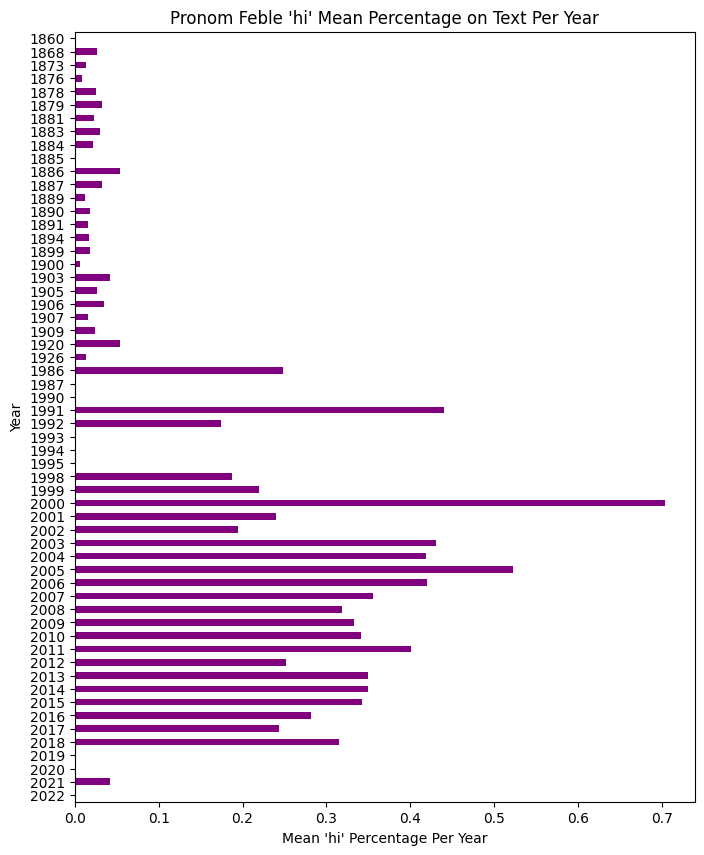

In [159]:
# plotting the "hi" distribution per year
# grouping by year
# getting average hi percentage per text per year
hi_grouped = tokscomplete_df.groupby("Year")["hi_percent"].mean()

plt.figure(figsize=(8, 10))
hi_grouped.plot(kind="barh", color="purple")
plt.xlabel("Mean 'hi' Percentage Per Year")
plt.ylabel("Year")
plt.title("Pronom Feble 'hi' Mean Percentage on Text Per Year")
plt.gca().invert_yaxis()  # inverting axis so it is from oldest to most recent
plt.show()

In [160]:
# correlation year-hi_percentages
from scipy import stats 
rho_hi, p_hi = stats.spearmanr(tokscomplete_df["Year"], tokscomplete_df["hi_percent"])
print(f"Hi% - rho: {rho_hi:.3f}, p-value: {p_hi:.4f}")

Hi% - rho: -0.034, p-value: 0.0000


**Conclusion on Pronoms Febles:**\
Both the rho result and the graph show us that there is no clear tendency in the use of the pronoun "hi". There's drops and increases through out the whole time-span and no clear increase or decrease of the use of "hi".

In [161]:
# saving new columns in a modified pickle of the dataframe
tokscomplete_df.to_pickle("LowAnalysisDF.pkl")

## 2. Time and space lexicon modification

The second symptom Dr. Junyent talks about is "time and space lexicon changes." In this section we will explore:\
**2.1:** the possibility of directional distinction losses with the verbs "anar" and "venir".\
**2.2:** a change in time lexicon looking at 2 past verb tenses "passat perifrastic" and "passat simple".

### 2.1 Directional distinction in anar and venir

Catalan, like in English, makes a clear distinction in **motion** towards and away from the speaker.\
For motions **away from the speaker** we use **"anar"**.\
For motions **towards the speaker** **"venir"** is used.\
This distinction is less strict in Spanish, therefore, seeing one of the two verbs increase in use taking over contexts where the other was usually used, would be indicating language substitution. Following another of Junyent's hypothesis, the distinction might be disolving, leading to an increase in use of one of the two verbs. 

**Note on the approach:**\
Since the verbs "anar" and "venir" have lots of conjugations for tense, person and number, it would be quite tedious to try to list all of them in our hunt for these in the texts. Therefore, we will use the lemmatized forms from Stanza's Catalan model Lemmatization. That way, we'll be able to find all "anar" and "venir" forms just by looking for the lemma. 

In [162]:
# creating nlp pipeline to tokenize the sentences in catalan 
#lang = ca(catalan)
nlp = stanza.Pipeline(lang="ca", processors="tokenize,mwt,pos,lemma")

2025-04-23 12:33:17 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-04-23 12:33:18 INFO: Downloaded file to /Users/janabruses/stanza_resources/resources.json
2025-04-23 12:33:18 INFO: Loading these models for language: ca (Catalan):
| Processor | Package         |
-------------------------------
| tokenize  | ancora          |
| mwt       | ancora          |
| pos       | ancora_nocharlm |
| lemma     | ancora_nocharlm |

2025-04-23 12:33:18 INFO: Using device: cpu
2025-04-23 12:33:18 INFO: Loading: tokenize
2025-04-23 12:33:18 INFO: Loading: mwt
2025-04-23 12:33:18 INFO: Loading: pos
2025-04-23 12:33:20 INFO: Loading: lemma
2025-04-23 12:33:20 INFO: Done loading processors!


In [163]:
# creating a 2 trial verb sequences containing various conjugations of the verbs "anar" (to go) and "venir" (to come)
# checking for lemmatization
# verb_doc = nlp (infinitive, 1.sing.prs, 2.sing.pst "perfet",  1.plur.pst "imperfet", 2.plur.pst simple, 3.plur.fut 
anar_doc = nlp("anar, vaig, has anat, anàvem, anàreu, aniran")
venir_doc = nlp("venir, vinc, has vingut, veníem, vinguéreu, vindran")
print("Lemmatization anar:")
print(*[f"word: {word.text+" "}\tlemma: {word.lemma}" for sent in anar_doc.sentences for word in sent.words], sep="\n")
print()
print("Lemmatization venir:")
print(*[f"word: {word.text+" "}\tlemma: {word.lemma}" for sent in venir_doc.sentences for word in sent.words], sep="\n")

Lemmatization anar:
word: anar 	lemma: anar
word: , 	lemma: ,
word: vaig 	lemma: anar
word: , 	lemma: ,
word: has 	lemma: haver
word: anat 	lemma: anar
word: , 	lemma: ,
word: anàvem 	lemma: anar
word: , 	lemma: ,
word: anàreu 	lemma: anàreu
word: , 	lemma: ,
word: aniran 	lemma: anar

Lemmatization venir:
word: venir 	lemma: venir
word: , 	lemma: ,
word: vinc 	lemma: venir
word: , 	lemma: ,
word: has 	lemma: haver
word: vingut 	lemma: venir
word: , 	lemma: ,
word: veníem 	lemma: venire
word: , 	lemma: ,
word: vinguéreu 	lemma: vinguér
word: , 	lemma: ,
word: vindran 	lemma: venir


**Comment on lematization:** The lemmatization worked out well overall, we find the correct lemma "anar" and "venir" for almost all of the conjugations we've tried changing in person, number and tense. The only mistake is with the past simple form, which is usually known more of as an archaic form. Still we will take that into account and look for "anar" and "venir" with "anar", "anàreu" and "venir", "vinguér", "venire" respectively. It still reduces our list very much and makes the process easier. 

**Lemmatization process:**
The documents were lemmatized using pitt supercomputing (CRC), as running it in my local machine would have been an incredibly long, maybe even impossible, process.\
The process correponds to the following line:

In [164]:
# tokscomplete_df["Lemmas"] = tokscomplete_df["Text"].apply(lambda doc: [word.lemma for sent in nlp(doc).sentences for word in sent.words])

The following commented out code and slurm file were used and can be found in the scripts folder in this repository with their respective extensions. [(link to scripts)](https://github.com/Data-Science-for-Linguists-2025/Linguistic-Markers-Catalan-Substitution/tree/main/scripts)\
After the lemmatization the resulting dataframe containing a row of text lemmas list was pickled.

In [165]:
python_script= '''
import pandas as pd
import stanza

low_analysis_df = pd.read_pickle("LowAnalysisDF.pkl")
nlp = stanza.Pipeline(lang='ca', processors='tokenize,mwt,pos,lemma')
anar_doc = nlp("anar, vaig, has anat, anàvem, anàreu, aniran")
venir_doc = nlp("venir, vinc, has vingut, veníem, vinguéreu, vindran")
print("Lemmatization anar:")
print(*[f'word: {word.text+" "}\tlemma: {word.lemma}' for sent in anar_doc.sentences for word in sent.words], sep='\n')
print()
print("Lemmatization venir:")
print(*[f'word: {word.text+" "}\tlemma: {word.lemma}' for sent in venir_doc.sentences for word in sent.words], sep='\n')

low_analysis_df["Lemmas"] = low_analysis_df["Text"].apply(lambda doc:
                                                          [word.lemma for
                                                           sent in nlp(doc).sentences
                                                           for word in sent.words])
low_analysis_df.to_pickle("lemmaComplete.pkl")
'''

In [166]:
slurm_file = '''
#!/usr/bin/env bash

#SBATCH --job-name=proj_lemmatization
#SBATCH --output=lemmatization.out
#SBATCH --nodes=1
#SBATCH --ntasks=3
#SBATCH --partition=smp
#SBATCH --cluster=smp
#SBATCH --mem-per-cpu=16000
#SBATCH --time=180

module load python/ondemand-jupyter-python3.11
python lemmatization_script.py
'''

In [167]:
# reading in the dataframe with lemma list column
lemma_df = pd.read_pickle("lemmaComplete.pkl")

In [168]:
# checking the new column
lemma_df = lemma_df.drop_duplicates(subset="Text", keep="first")
lemma_df.head(3)

,Year,Line_id,Text,Text_len,toks,Len_toks,toks_low,hi,-hi,hi_count,hi_percent,Lemmas
0,1926,Discurs llegit per... donar a conèxer la perso...,"L'home que per amor al estudi, impulsat per un...",37497,"[L', home, que, per, amor, al, estudi, ,, impu...",7267,"[l', home, que, per, amor, al, estudi, ,, impu...","{(n', hi, hagi)}",{},1,0.013761,"[el, home, que, per, amor, a, el, estudi, ,, i..."
1,1920,Parlament llegit en la festa inaugural de l'Or...,"Cantaires de la Garriga, Senyores i senyors:\n...",9253,"[Cantaires, de, la, Garriga, ,, Senyores, i, s...",1865,"[cantaires, de, la, garriga, ,, senyores, i, s...","{(m', hi, vaig)}",{},1,0.053619,"[Cantaires, de, el, Garriga, ,, Senyores, i, s..."
2,1900,Discurs-pròlec,Discurs-prolec Llegit en la societat mèdic-far...,73881,"[Discurs-prolec, Llegit, en, la, societat, mèd...",14727,"[discurs-prolec, llegit, en, la, societat, mèd...","{(pròu, hi, gosaria)}",{},1,0.006790,"[Discurs-prolec, llegit, en, el, societat, mèd..."


**Comment:** Now that we have lemmatized our text we will hunt for instances in any conjugation of "anar" and "venir", and see if we can find any trends of one taking over the other's use. 

In [169]:
# counting instances of anar and venir in each of the lemma lists for each text piece
lemma_df["Anar_count"] = lemma_df["Lemmas"].apply(lambda x: x.count("anar") + x.count("anàreu"))
lemma_df["Venir_count"] = lemma_df["Lemmas"].apply(lambda x: x.count("venir") + x.count("vinguér") + x.count("venire"))

In [170]:
lemma_df.head(3)

,Year,Line_id,Text,Text_len,toks,Len_toks,toks_low,hi,-hi,hi_count,hi_percent,Lemmas,Anar_count,Venir_count
0,1926,Discurs llegit per... donar a conèxer la perso...,"L'home que per amor al estudi, impulsat per un...",37497,"[L', home, que, per, amor, al, estudi, ,, impu...",7267,"[l', home, que, per, amor, al, estudi, ,, impu...","{(n', hi, hagi)}",{},1,0.013761,"[el, home, que, per, amor, a, el, estudi, ,, i...",61,2
1,1920,Parlament llegit en la festa inaugural de l'Or...,"Cantaires de la Garriga, Senyores i senyors:\n...",9253,"[Cantaires, de, la, Garriga, ,, Senyores, i, s...",1865,"[cantaires, de, la, garriga, ,, senyores, i, s...","{(m', hi, vaig)}",{},1,0.053619,"[Cantaires, de, el, Garriga, ,, Senyores, i, s...",8,0
2,1900,Discurs-pròlec,Discurs-prolec Llegit en la societat mèdic-far...,73881,"[Discurs-prolec, Llegit, en, la, societat, mèd...",14727,"[discurs-prolec, llegit, en, la, societat, mèd...","{(pròu, hi, gosaria)}",{},1,0.006790,"[Discurs-prolec, llegit, en, el, societat, mèd...",19,5


In [171]:
# since we'll be comparing proportions multiple times, lets create a function for it:
def proportion_comparison_df(df, el1, el2):
    count1_name = f"{el1}_count"
    count2_name = f"{el2}_count"
    el1_prop_df = (df.groupby("Year")[count1_name].sum()/lemma_df.groupby("Year")["Len_toks"].sum()*100).reset_index()
    el2_prop_df = (df.groupby("Year")[count2_name].sum()/lemma_df.groupby("Year")["Len_toks"].sum()*100).reset_index()
    el1_prop_df = el1_prop_df.rename(columns ={"Year": "Year", 0:f"{el1}_percent"}) 
    el2_prop_df = el2_prop_df.rename(columns ={"Year": "Year", 0:f"{el2}_percent"}) 
    comparison_df = pd.merge(el1_prop_df, el2_prop_df, on="Year")      
    return comparison_df

In [172]:
lemma_df["Anar_percent"] = lemma_df.apply(lambda x: proportion(x, "Anar_count"), axis=1)
lemma_df["Venir_percent"] = lemma_df.apply(lambda x: proportion(x, "Venir_count"), axis=1)

In [173]:
directionVerbs_df = proportion_comparison_df(lemma_df, "Anar", "Venir")

In [174]:
directionVerbs_df.head()

,Year,Anar_percent,Venir_percent
0,1860,0.000000,0.104275
1,1868,0.026759,0.347873
2,1873,0.155179,0.116384
3,1876,0.211039,0.040584
4,1878,0.172159,0.024594


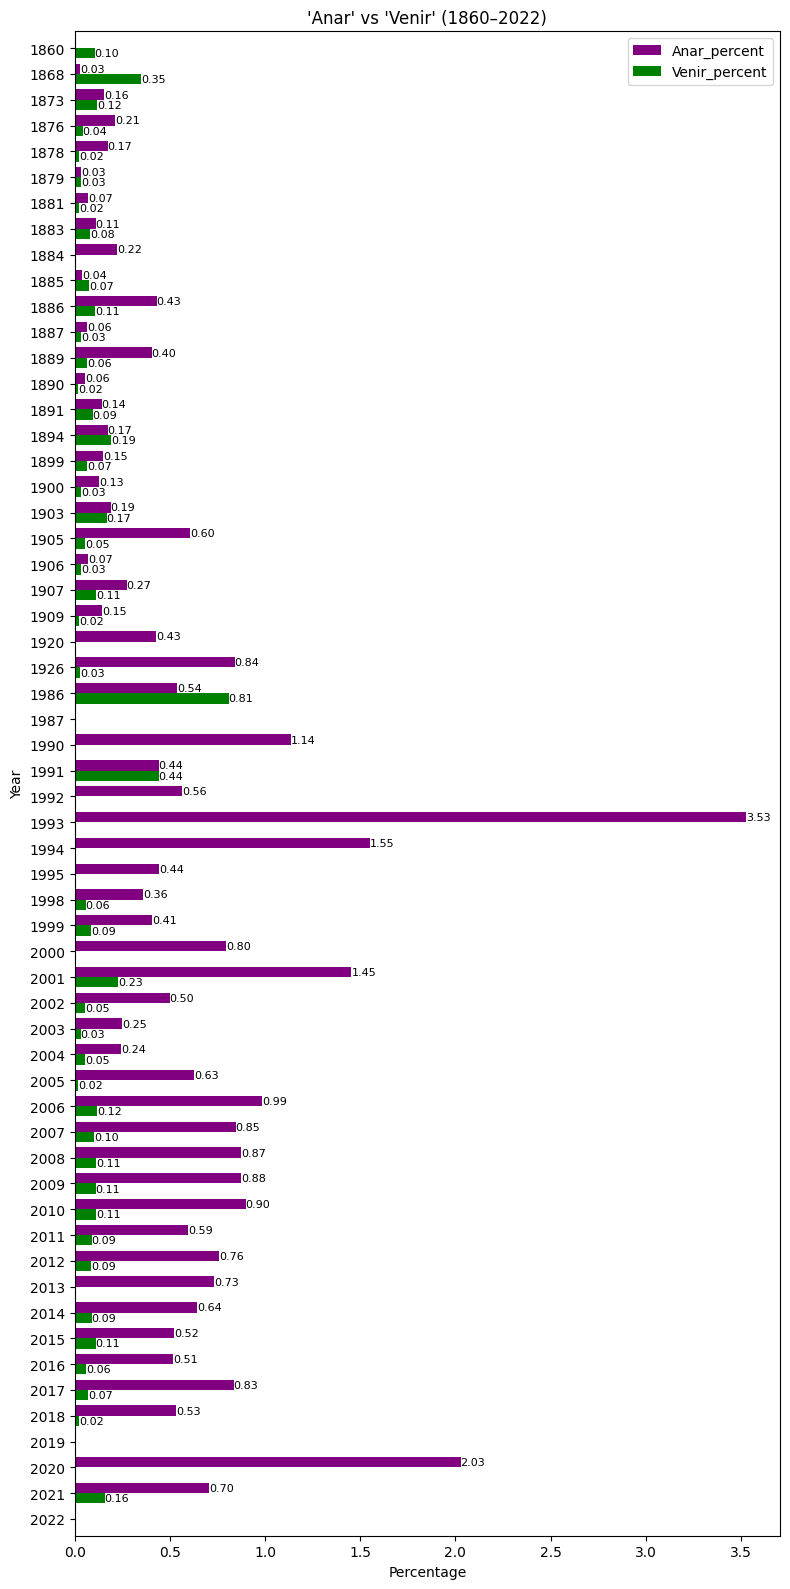

In [175]:
# plotting anar vs venir
ax = directionVerbs_df.plot.barh(
    y=["Anar_percent", "Venir_percent"],
    x="Year",
    figsize=(8, 16),  
    width=0.8,
    color = ["purple", "green"]
)

# regression line
x = directionVerbs_df.index
y = directionVerbs_df['Anar_percent']
coef = np.polyfit(x, y, 1)  # 1 = linear
poly1d_fn = np.poly1d(coef)

# adding value annotations
for p in ax.patches:
    w = p.get_width()
    if w > 0:
        ax.annotate(f"{w:.2f}", 
                    (w, p.get_y() + p.get_height() / 2),
                    va="center", ha="left", fontsize=8)

ax.set_title("'Anar' vs 'Venir' (1860–2022)", fontsize=12)
ax.set_xlabel("Percentage")
ax.set_ylabel("Year")
ax.invert_yaxis()  # from olderst to most recent
plt.tight_layout()
plt.show()

In [176]:
# correlation year-percentages
rho_anar, p_anar = spearmanr(directionVerbs_df["Year"], directionVerbs_df["Anar_percent"])
rho_venir, p_venir = spearmanr(directionVerbs_df["Year"], directionVerbs_df["Venir_percent"])
print(f"Anar% - rho: {rho_anar: 4f}, p-value: {p_anar:.4f}")
print(f"Venir% - rho: {rho_venir:.4f}, p-value: {p_venir:.4f}")

Anar% - rho:  0.571376, p-value: 0.0000
Venir% - rho: -0.0808, p-value: 0.5464


In [177]:
# difference through years
directionVerbs_df["Diff"] = directionVerbs_df["Anar_percent"] - directionVerbs_df["Venir_percent"]
rho_diff, p_diff = spearmanr(directionVerbs_df["Year"], directionVerbs_df["Diff"])
print(f"Diferència (Anar% - Venir%) - rho: {rho_diff:.4f}, p-value: {p_diff:.4f}")

Diferència (Anar% - Venir%) - rho: 0.5581, p-value: 0.0000


**Conclusion on direction verbs**\
The use of the verb "anar" (to go) increases significantly through out the years, while "venir" (to come,) does not show any significant change.\
The difference in the use of the two verbs, clearly increases with the increase in the use of "anar". This could suggest that anar is taking over some of the situations in which venir used to be used, as there is a significant tendency in the difference of 0.55, and in the increase of "Anar" of 0.56. However, since "Venir" does not experience any drop, the meaning and functions of "Anar" might just be getting extended in other ways, not necessarly taking over the function of "Venir".

### 2.2 Shift from "perifràstic" past to simple past

**A bit of grammar background on the perifrastic past:**

The Perifrastic Past in Catalan is a verb tense used to express past tense actions that were done in the past and have been finished.\
It is characteristic and a cornestone of Catalan as no neolatin language uses a Perifrastic Past.\
It has the same value and sense as Simple Past. In English *"I went"*.\
It is formed with the auxiliary form of the verb "anar" and the main verb in its infinitive form.\
Anar (to go) is conjugated in the present tense.
| **Pattern:** | **(subj)** | **present tense anar** | **main verb inf** |
|:---|:---|:---|:---|
|(1st Sing.) | Jo	| vaig | parlar |
|(2nd Sing.) | Tu	| vas/vares | parlar |
|(3rd Sing.) | Ell/Ella | va | parlar |
|(1st Plur.) | Nosaltres | vam/vàrem | parlar |
|(2nd Plur.) | Vosaltres | vau/vàreu | parlar |
|(3rd Plur.) | Ells / Elles |	van/varen |	parlar |

\
Another note, that will be helpful in our search for this tense is that all infinitives in Catalan belong to one of 3 conjugations that have a particular ending.\
Inifitive form verbs of the **first conjugation** finish in **"-ar"**, as the previous example "parlar" or for another example "menjar".\
**Second conjugation** verbs infinitives end in **"-er"** like "saber" or **"-re"** like "pretendre".\
**Third conjugugation** infinitives end in **"-ir"** like "dormir".

All forms follow this rule and there are no irregular forms.

Given the strong regularity let's go straight into takeling the perifrastic past hunt.

In [178]:
# creating a function to find pronom febles and their context
def get_pstperif(text):
    '''
    takes in a text and returns a list of found "passat perifrastic" forms in the text
    '''
    # regex breakdown:
    # \b -> word boundary
    # (?:vaig|vas|vares|va|vam|vàrem|vau|vàreu|van|varen) -> has to match one of the auxiliar forms 
    # \s+ -> zero or more whitespace characters (the space between the aux and main verb)
    # (?:ar|er|re|ir) -> has to match one of the infinitive endings
    # this pattern ensures we are capturing only compound forms and they are "Passat Perifrastic" as their aux is "anar"
    target = r"\b(?:vaig|vas|vares|va|vam|vàrem|vau|vàreu|van|varen)\s+\w+(?:ar|er|re|ir)"
    found = re.findall(target, text, flags=re.IGNORECASE)
    return found

In [179]:
# getting all passat perifrastics forms as a list and storing them in a column
lemma_df["PstPerif"] = lemma_df["Text"].apply(get_pstperif)

In [180]:
# counting the passat perifrastic forms per row and storing that count as a new column
lemma_df["Pstp_count"] = lemma_df["PstPerif"].apply(len)

In [181]:
# checking the new columns
lemma_df.head(2)

,Year,Line_id,Text,Text_len,toks,Len_toks,toks_low,hi,-hi,hi_count,hi_percent,Lemmas,Anar_count,Venir_count,Anar_percent,Venir_percent,PstPerif,Pstp_count
0,1926,Discurs llegit per... donar a conèxer la perso...,"L'home que per amor al estudi, impulsat per un...",37497,"[L', home, que, per, amor, al, estudi, ,, impu...",7267,"[l', home, que, per, amor, al, estudi, ,, impu...","{(n', hi, hagi)}",{},1,0.013761,"[el, home, que, per, amor, a, el, estudi, ,, i...",61,2,0.839411,0.027522,"[va dedicar, va erigir, va fer, va interrogar,...",35
1,1920,Parlament llegit en la festa inaugural de l'Or...,"Cantaires de la Garriga, Senyores i senyors:\n...",9253,"[Cantaires, de, la, Garriga, ,, Senyores, i, s...",1865,"[cantaires, de, la, garriga, ,, senyores, i, s...","{(m', hi, vaig)}",{},1,0.053619,"[Cantaires, de, el, Garriga, ,, Senyores, i, s...",8,0,0.428954,0.000000,"[vaig ésser, vaig començar, vaig trobar, vàrem...",4


**Comment:** We have now found and counted all the Passat Perifrastic forms in the texts stored in the "PstPerif" column and counted on the "Pstp_count" column. We will now explore the counts and years to see if there is a drop in the use of Passat Perifrastic that would portray a shift towards other tenses, likely to the influence of other romance languages.\
To analyze the count since it is heavly dependent on text length, we will create a new column with the percentage of Passat Perifrastic from the total tokens of the text piece. We will then use that percentage instead of the raw count to analyze the progression over time.

In [182]:
lemma_df["Pstp_percent"] = lemma_df.apply(lambda x: proportion(x, "Pstp_count"), axis=1)

In [183]:
lemma_df.head(2)

,Year,Line_id,Text,Text_len,toks,Len_toks,toks_low,hi,-hi,hi_count,hi_percent,Lemmas,Anar_count,Venir_count,Anar_percent,Venir_percent,PstPerif,Pstp_count,Pstp_percent
0,1926,Discurs llegit per... donar a conèxer la perso...,"L'home que per amor al estudi, impulsat per un...",37497,"[L', home, que, per, amor, al, estudi, ,, impu...",7267,"[l', home, que, per, amor, al, estudi, ,, impu...","{(n', hi, hagi)}",{},1,0.013761,"[el, home, que, per, amor, a, el, estudi, ,, i...",61,2,0.839411,0.027522,"[va dedicar, va erigir, va fer, va interrogar,...",35,0.481629
1,1920,Parlament llegit en la festa inaugural de l'Or...,"Cantaires de la Garriga, Senyores i senyors:\n...",9253,"[Cantaires, de, la, Garriga, ,, Senyores, i, s...",1865,"[cantaires, de, la, garriga, ,, senyores, i, s...","{(m', hi, vaig)}",{},1,0.053619,"[Cantaires, de, el, Garriga, ,, Senyores, i, s...",8,0,0.428954,0.000000,"[vaig ésser, vaig començar, vaig trobar, vàrem...",4,0.214477


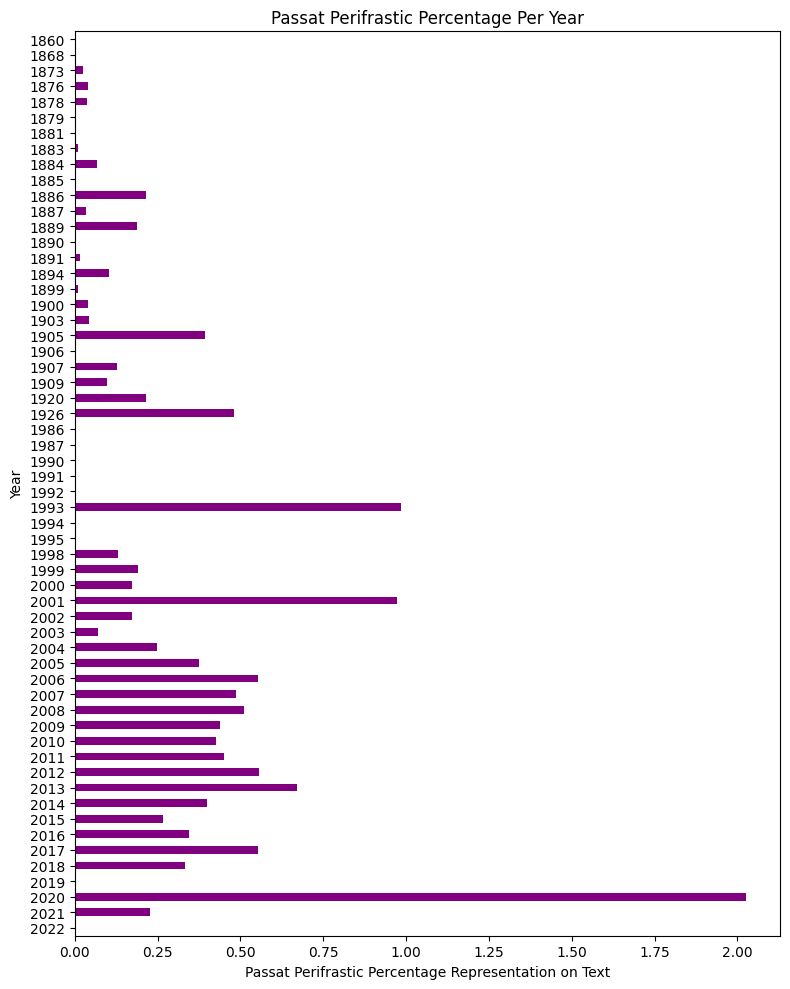

In [184]:
# grouping by year
# getting mean percentage of hi per text per year
df_grouped = lemma_df.groupby("Year")["Pstp_percent"].mean()

plt.figure(figsize=(8, 10))
df_grouped.plot(kind="barh", color="purple")
plt.xlabel("Passat Perifrastic Percentage Representation on Text")
plt.ylabel("Year")
plt.title("Passat Perifrastic Percentage Per Year")
plt.gca().invert_yaxis()  # Opcional, per invertir l'ordre de les etiquetes
plt.tight_layout()
plt.show()

In [185]:
# correlation year-hi_percentages
rho_pstp, p_pstp = spearmanr(lemma_df["Year"], lemma_df["Pstp_percent"])
print(f"Passat Perifràstic% - rho: {rho_pstp:.4f}, p-value: {p_pstp:.4f}")

Passat Perifràstic% - rho: -0.0406, p-value: 0.0000


**Conclusion**\
We could already see with the graph, and can suport with the rho result that there is no clear tendency in the use of Passat Perifràstic through out the years, there are sudden increases and decreases that do not show any clear pattern. 

## 3. Syntactic restructuring

The last symptom Dr. Junyent points out is syntactic restructuring. Mentioning specifically pronominalization of non-reflexive verbs, that we will explore in 3.2.\
We will also look for syntactic restructuring with the comparison of the verbal periphrases "tenir que", a famous "castellanisme" (something like spanglish but between Catalan and Spanish) and "haver de", the Catalan periphrase that would traditionally be used in the context and considered correct.

### 3.1 Tenir que vs haver de

**Background info**\
In Catalan, the verb "tenir" is used for possession. "**To have** a cat" would be "**Tenir** un gat". However, "tenir" is not used for tasks or obligations. Instead, we use the verbal periphrase "haver de." "**I have to** clean" would be "**He de** netejar," "he" being "haver" conjugated 1st person singular present.\
However, in Spanish, the periphrase "tener que" is used for the same context and purpose. "Tengo que limpiar," "tengo" being 1st person singular for "tener".\
Because in Catalan, we do have the verb "tenir" for possession, "tenir que," mirroring the Spanish "tener que" is sometimes being used, reproducing a Spanish pattern that sounds unnatural to many speakers' ears as it is like a direct translation from Spanish.\
In the following step of the analysis, we will look for instances of "tenir que" in our data. We'll see if there is any change in its frequency of use.

Similar to previous analysis sections, to avoid listing all the possible "tenir que" and "haver de" constructions for every possible person, number, and tense so we don't miss any instance of the constructions, we will use lemmatization.\
However, to ensure these expressions are correctly lemmatized, we will first run a trial lemmatiation on a couple of example sentences. 

In [186]:
# creating 2 trial sequences containing various conjugations of the constructions "haver de" and "tenir que" (have to)
# checking for lemmatization
# verb_doc = nlp (infinitive, 1.sing.prs, 2.sing.pst "perfet",  1.plur.pst "imperfet", 2.plur.pst simple, 3.plur.fut 
haverde_doc = nlp("haver de, he de, has hagut de, havíem de, haguérem de, hauran de")
tenirque_doc = nlp("tenir que, tinc que, has tingut que, teníem que, tinguérem que, tindran que")
print("Lemmatization haver de:")
print(*[f"word: {word.text+" "}\tlemma: {word.lemma}" for sent in haverde_doc.sentences for word in sent.words], sep="\n")
print()
print("Lemmatization tenir que:")
print(*[f"word: {word.text+" "}\tlemma: {word.lemma}" for sent in tenirque_doc.sentences for word in sent.words], sep="\n")

Lemmatization haver de:
word: haver 	lemma: haver
word: de 	lemma: de
word: , 	lemma: ,
word: he 	lemma: haver
word: de 	lemma: de
word: , 	lemma: ,
word: has 	lemma: haver
word: hagut 	lemma: haver
word: de 	lemma: de
word: , 	lemma: ,
word: havíem 	lemma: haver
word: de 	lemma: de
word: , 	lemma: ,
word: haguérem 	lemma: haver
word: de 	lemma: de
word: , 	lemma: ,
word: hauran 	lemma: haver
word: de 	lemma: de

Lemmatization tenir que:
word: tenir 	lemma: tenir
word: que 	lemma: que
word: , 	lemma: ,
word: tinc 	lemma: tenir
word: que 	lemma: que
word: , 	lemma: ,
word: has 	lemma: haver
word: tingut 	lemma: tenir
word: que 	lemma: que
word: , 	lemma: ,
word: teníem 	lemma: tenir
word: que 	lemma: que
word: , 	lemma: ,
word: tinguérem 	lemma: tenir
word: que 	lemma: que
word: , 	lemma: ,
word: tindran 	lemma: tenir
word: que 	lemma: que


**Comment on lemmatization**\
All the forms we've tried changing tense, number and person have been correctly lemmatized into "haver de" or tenir que".\
Since we can use this lemmatization we will reuse the "Lemmas" column in our dataframe.

In [187]:
from nltk.util import bigrams

def periphrase_counter(unigram_list, target_bigram):
    '''
    takes in:
    (1) unigram list (our lemmas list)
    (2) target bigram in tuple format
    returns the count of that tuple in the bigram list
    '''
    bigram_list = list(bigrams(unigram_list))
    return bigram_list.count(target_bigram)

# mini trial-run of the function has been commented out
#mini_lemmas = ["haver", "de", "c", "d", "e"]
#print(periphrase_counter(mini_lemmas, ("haver", "de")))

In [188]:
lemma_df["HaverDe_count"] = lemma_df["Lemmas"].apply(lambda x: periphrase_counter(x, ("haver", "de")))
lemma_df["TenirQue_count"] = lemma_df["Lemmas"].apply(lambda x: periphrase_counter(x, ("tenir", "que")))

In [189]:
lemma_df.head(2)

,Year,Line_id,Text,Text_len,toks,Len_toks,toks_low,hi,-hi,hi_count,...,Lemmas,Anar_count,Venir_count,Anar_percent,Venir_percent,PstPerif,Pstp_count,Pstp_percent,HaverDe_count,TenirQue_count
0,1926,Discurs llegit per... donar a conèxer la perso...,"L'home que per amor al estudi, impulsat per un...",37497,"[L', home, que, per, amor, al, estudi, ,, impu...",7267,"[l', home, que, per, amor, al, estudi, ,, impu...","{(n', hi, hagi)}",{},1,...,"[el, home, que, per, amor, a, el, estudi, ,, i...",61,2,0.839411,0.027522,"[va dedicar, va erigir, va fer, va interrogar,...",35,0.481629,15,0
1,1920,Parlament llegit en la festa inaugural de l'Or...,"Cantaires de la Garriga, Senyores i senyors:\n...",9253,"[Cantaires, de, la, Garriga, ,, Senyores, i, s...",1865,"[cantaires, de, la, garriga, ,, senyores, i, s...","{(m', hi, vaig)}",{},1,...,"[Cantaires, de, el, Garriga, ,, Senyores, i, s...",8,0,0.428954,0.000000,"[vaig ésser, vaig començar, vaig trobar, vàrem...",4,0.214477,1,0


In [190]:
periphrases_df = proportion_comparison_df(lemma_df, "HaverDe", "TenirQue")

In [191]:
# columns for percentages for the 2nd part of the analysis
lemma_df["HaverDe_percent"] = lemma_df.apply(lambda x: proportion(x, "HaverDe_count"), axis=1)
lemma_df["TenirQue_percent"] = lemma_df.apply(lambda x: proportion(x, "TenirQue_count"), axis=1)

In [192]:
# checking the resulting mini dataframe first 2 years
periphrases_df.head(2)

,Year,HaverDe_percent,TenirQue_percent
0,1860,0.260688,0.0
1,1868,0.080278,0.0


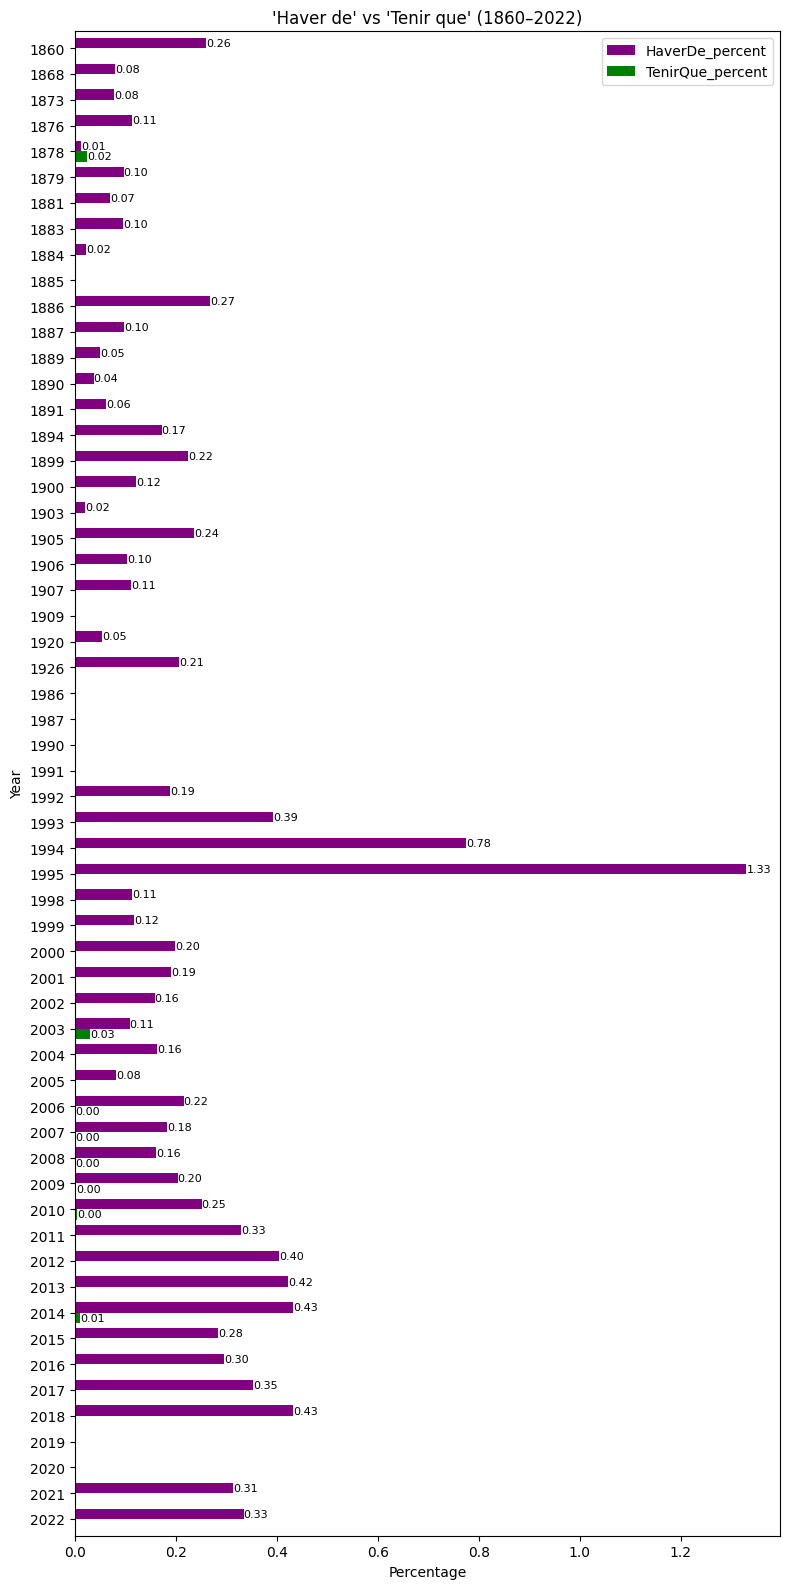

In [193]:
# plotting haver de vs tenir que per year
ax = periphrases_df.plot.barh(
    y=["HaverDe_percent", "TenirQue_percent"],
    x="Year",
    figsize=(8, 16),  
    width=0.8,
    color = ["purple", "green"]
)

# adding value annotations
for p in ax.patches:
    w = p.get_width()
    if w > 0:
        ax.annotate(f"{w:.2f}", 
                    (w, p.get_y() + p.get_height() / 2),
                    va="center", ha="left", fontsize=8)

ax.set_title("'Haver de' vs 'Tenir que' (1860–2022)", fontsize=12)
ax.set_xlabel("Percentage")
ax.set_ylabel("Year")
ax.invert_yaxis()  # from olderst to most recent
plt.tight_layout()
plt.show()

In [194]:
# correlation year-hi_percentages
rho_pstp, p_pstp = spearmanr(lemma_df["Year"], lemma_df["Pstp_percent"])
print(f"Passat Perifràstic% - rho: {rho_pstp:.4f}, p-value: {p_pstp:.4f}")

Passat Perifràstic% - rho: -0.0406, p-value: 0.0000


### 3.2 Pronominalization of movement verbs

**Grammatical background:**\
Pronominal verbs are verbs that require a reflexive pronoun.\
For example, for the English "I get dressed", in Catalan, we would say "**Em** vesteixo," which would be more literally "I get dressed **myself**".\
In Catalan, we have many pronominal verbs, as does Spanish.\
However, we are pronominalizing verbs that used to be non-pronominal because of the Spanish influence, specifically movement verbs, notes Dr. Junyent. In her examples, we find "puja't a la bicicleta" instead of "puja a la bicicleta," which would be "get yourself up on the bicycle" instead of "get up on the bicycle."

To find pronominalizations, we will need to bring in another layer of language processing for our dataframe.\
That is because pronominalizations are very "irregular" in form and position, as they are clitics in Catalan.

First, we can narrow down to looking for "Personal Pronouns", as we are dealing with verb pronominalizations.\
In Catalan there are 2 types of Personal Pronouns that refer to a person or entity: Pronoms Personals Forts, that stand by themselves, and Pronoms Personals Febles, which are clitic pronouns that can work both as preclitic (preciding the verb) and enclitic (following the verb.) The later are the ones used for reflexive verbs/ verb pronominalization.
For example, for the second grammatical person we find the following forms:
Sin
|  | Before verb (consonant initial)| Before verb (vowel initial)| After Verb (consonant ending) | After Verb (vowel ending) |
| ---- | ---- | ---- | ---- | ---- |
2nd Person Sing | et | t' | -te | 't |
2nd Person Plur | us | us | -vos | -us |

Moreover, we can also note from this example that in some cases in the ortography we separate the clitic by a space, in others only with an apostrophe, and sometimes with a dash.\
On top of that, another challenge is that stanza treats this differently for tokenization. We saw on previous explorations that proclitics are treated as separate tokens, while enclitics are tokenized along with the word they are attached to. 

Using Stanza's dependency parsing was my first thought. However, as we see in the next example it didn't result as expected.

In [195]:
import stanza

nlp = stanza.Pipeline(lang='ca', processors='tokenize,mwt,pos,lemma,depparse')

2025-04-23 12:33:27 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-04-23 12:33:28 INFO: Downloaded file to /Users/janabruses/stanza_resources/resources.json
2025-04-23 12:33:28 INFO: Loading these models for language: ca (Catalan):
| Processor | Package         |
-------------------------------
| tokenize  | ancora          |
| mwt       | ancora          |
| pos       | ancora_nocharlm |
| lemma     | ancora_nocharlm |
| depparse  | ancora_nocharlm |

2025-04-23 12:33:28 INFO: Using device: cpu
2025-04-23 12:33:28 INFO: Loading: tokenize
2025-04-23 12:33:28 INFO: Loading: mwt
2025-04-23 12:33:28 INFO: Loading: pos
2025-04-23 12:33:30 INFO: Loading: lemma
2025-04-23 12:33:31 INFO: Loading: depparse
2025-04-23 12:33:31 INFO: Done loading processors!


In [196]:
print("Example 1:")
doc = nlp("Estima't molt")
print(*[f'id: {word.id}\tword: {word.text}\thead id: {word.head}\thead: {sent.words[word.head-1].text if word.head > 0 else "root"}\tdeprel: {word.deprel}' for sent in doc.sentences for word in sent.words], sep='\n')

Example 1:
id: 1	word: Estima't	head id: 0	head: root	deprel: root
id: 2	word: molt	head id: 1	head: Estima't	deprel: advmod


In [197]:
print("Example 2:")
doc1 = nlp("T'estimo molt")
print(*[f'id: {word.id}\tword: {word.text}\thead id: {word.head}\thead: {sent.words[word.head-1].text if word.head > 0 else "root"}\tdeprel: {word.deprel}' for sent in doc1.sentences for word in sent.words], sep='\n')

Example 2:
id: 1	word: T'	head id: 2	head: estimo	deprel: obj
id: 2	word: estimo	head id: 0	head: root	deprel: root
id: 3	word: molt	head id: 2	head: estimo	deprel: advmod


**Comment:**\
We see that even though we have the unstressed pronoun "t'" in both situations. The proclitic (example 2), is corretly tagged as the object, of the verb "espera" as head. However, when the "t" is an enclitic in "espera't", as it is tokenized along the verb, the clitic and pronominalization goes is missing.\
The issue is that, since the lost information comes from the tokenization, no Stanza parsing model will be able to overcome this gap.\
Consequently, we need to bring in a new approach.

In [198]:
# trying out POS
nlp = stanza.Pipeline(lang='ca', processors='tokenize,mwt,pos')

2025-04-23 12:33:31 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-04-23 12:33:31 INFO: Downloaded file to /Users/janabruses/stanza_resources/resources.json
2025-04-23 12:33:32 INFO: Loading these models for language: ca (Catalan):
| Processor | Package         |
-------------------------------
| tokenize  | ancora          |
| mwt       | ancora          |
| pos       | ancora_nocharlm |

2025-04-23 12:33:32 INFO: Using device: cpu
2025-04-23 12:33:32 INFO: Loading: tokenize
2025-04-23 12:33:32 INFO: Loading: mwt
2025-04-23 12:33:32 INFO: Loading: pos
2025-04-23 12:33:33 INFO: Done loading processors!


In [199]:
print("Example 1:")
doc = nlp("T'estimo molt")
print(*[f'word: {word.text}\tupos: {word.upos}\txpos: {word.xpos}\tfeats: {word.feats if word.feats else "_"}' for sent in doc.sentences for word in sent.words], sep='\n')

Example 1:
word: T'	upos: PRON	xpos: pp1cs000	feats: Case=Acc,Dat|Number=Sing|Person=2|PrepCase=Npr|PronType=Prs
word: estimo	upos: VERB	xpos: vmip1s0	feats: Mood=Ind|Number=Sing|Person=1|Tense=Pres|VerbForm=Fin
word: molt	upos: ADV	xpos: rg	feats: _


In [200]:
print("Example 2:")
doc1 = nlp("diu puja't a la bicicleta")
print(*[f'word: {word.text}\tupos: {word.upos}\txpos: {word.xpos}\tfeats: {word.feats if word.feats else "_"}' for sent in doc1.sentences for word in sent.words], sep='\n')

Example 2:
word: diu	upos: VERB	xpos: vmip3s0	feats: Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin
word: puja't	upos: VERB	xpos: vmg0000	feats: VerbForm=Ger
word: a	upos: ADP	xpos: sps00	feats: _
word: la	upos: DET	xpos: da0fs0	feats: Definite=Def|Gender=Fem|Number=Sing|PronType=Art
word: bicicleta	upos: NOUN	xpos: ncfs000	feats: Gender=Fem|Number=Sing


**Comment:**
With the POS tag we can even see that it does give us the information that "Estima't" is the full PROPN and not simply a verb, so the information is in fact not lost.\
The issue is still, the multiple situations we encounter, we will need to come up with a method that covers booth possibilities.

Let's see if the POS tag feats acrtually gives us some information about the pronoun being stressed or unstressed that allows us to determine that is in fact pronominalizing the verb and not a subject pronoun like "You" in Catalan "Tu."

In [201]:
print("Example 3:")
doc2 = nlp("Tu menges xocolata")
print(*[f'word: {word.text}\tupos: {word.upos}\txpos: {word.xpos}\tfeats: {word.feats if word.feats else "_"}' for sent in doc2.sentences for word in sent.words], sep='\n')

Example 3:
word: Tu	upos: PRON	xpos: pp1cs000	feats: Case=Acc,Dat|Number=Sing|Person=2|PrepCase=Npr|PronType=Prs
word: menges	upos: VERB	xpos: vmip3p0	feats: Mood=Ind|Number=Plur|Person=3|Tense=Pres|VerbForm=Fin
word: xocolata	upos: NOUN	xpos: ncfs000	feats: Gender=Fem|Number=Sing


"Tu" and "T'" are tagged exacly the same, so it won't help us.

We do not include the following since they are the "pronoms neutres" that we analyzed previously, not present in Spanish, which is not what we are looking for in this section:\
ho, -ho\
en, n', -ne, 'n\
hi, -hi

In [202]:
# this is basically what the following code will be doing at the larger scale on Pitt CRC
pron_doc = nlp("se les vol menjar totes perque li agraden molt")
print("POS:")
print([(word.text, word.upos) for
        sent in nlp(pron_doc).sentences
        for word in sent.words])

POS:
[('se', 'PRON'), ('les', 'PRON'), ('vol', 'VERB'), ('menjar', 'VERB'), ('totes', 'PRON'), ('perque', 'SCONJ'), ('li', 'PRON'), ('agraden', 'VERB'), ('molt', 'ADV')]


In [203]:
python_script= '''
import pandas as pd
import stanza

low_analysis_df = pd.read_pickle("LowAnalysisDF.pkl")
nlp = stanza.Pipeline(lang='ca', processors='tokenize,mwt,pos,lemma')
pronoms_mini_doc = nlp("se les vol menjar totes perque li agraden molt")
print("word-POS tupples:")
print([(word.text, word.upos) for
        sent in nlp(doc).sentences
        for word in sent.words]))
print()

low_analysis_df["POS"] = low_analysis_df["Text"].apply(lambda doc:
                                                        [(word.text, word.upos) for
                                                        sent in nlp(doc).sentences
                                                        for word in sent.words])
low_analysis_df.to_pickle("POS.pkl")
'''

In [204]:
slurm_file = '''
#!/usr/bin/env bash

#SBATCH --job-name=proj_postag
#SBATCH --output=pos_tag.out
#SBATCH --nodes=1
#SBATCH --ntasks=3
#SBATCH --partition=smp
#SBATCH --cluster=smp
#SBATCH --mem-per-cpu=16000
#SBATCH --time=180

module load python/ondemand-jupyter-python3.11
python pos_script.py
'''

In [205]:
# reading in the dataframe with (word-POS) column
pos_df = pd.read_pickle("POS.pkl")

In [206]:
pos_df = pos_df.drop_duplicates(subset="Text", keep="first")

In [207]:
# keeping only the POS and the id so we can include the POS tupple lists in our current dataframe (with all previous analysis columns)
pos_only = pos_df[["Line_id","POS"]]

In [208]:
# merging the POS tags with the lemma_df for the current dataframe
current_df = lemma_df.merge(pos_only, on="Line_id")

In [209]:
current_df.tail(2)

,Year,Line_id,Text,Text_len,toks,Len_toks,toks_low,hi,-hi,hi_count,...,Anar_percent,Venir_percent,PstPerif,Pstp_count,Pstp_percent,HaverDe_count,TenirQue_count,HaverDe_percent,TenirQue_percent,POS
12093634,1986,Veu B00:01:33,Y los dos coches que pasaban en aquel momento....,193,"[Y, los, dos, coches, que, pasaban, en, aquel,...",50,"[y, los, dos, coches, que, pasaban, en, aquel,...","{(punta, hi, ha)}",{},1,...,2.0,0.0,[],0,0.0,0,0,0.0,0.0,"[(Pel, ADP), (geòleg, NOUN), (., PUNCT)]"
12093635,1986,Veu B00:01:33,Y los dos coches que pasaban en aquel momento....,193,"[Y, los, dos, coches, que, pasaban, en, aquel,...",50,"[y, los, dos, coches, que, pasaban, en, aquel,...","{(punta, hi, ha)}",{},1,...,2.0,0.0,[],0,0.0,0,0,0.0,0.0,"[(Y, CCONJ), (los, DET), (dos, NUM), (coches, ..."


In [210]:
def get_pronominalized(pos_list):
    '''
    takes in a text and returns a list of found pronominalized verbs in the text
    '''
    enclitics = re.compile(r".*(?:-me|'m|’m|-nos|'ns|’ns|-te|'t|’t|-vos|-us|'ns|’ns|-se|'s|’s)", re.IGNORECASE)
    proclitics = re.compile(r"\b(?:em|m'|m’|ens|et|t'|t’|us|es|s'|s’)", re.IGNORECASE)

    reflexV_list = []
    for i, (word, pos) in enumerate(pos_list):
        if pos == "VERB":
            # enclitic
            if enclitics.match(word):
                reflexV_list.append(word)

            #proclitics
            prev = i-1
            proclitic = []
            isReflexive = False
            while prev >= 0:
                prev_word, prev_pos = pos_list[prev]
                if prev_pos == "PRON" and proclitics.match(prev_word):
                    proclitic.insert(0, prev_word)
                    prev -= 1
                    isReflexive = True;
                elif prev_pos == "AUX" or prev_pos == "ADP": 
                    proclitic.insert(0, prev_word)
                    prev -= 1
                else:
                    break
            
            if proclitic and isReflexive:
                proclitic.append(word)
                reflexV_list.append(proclitic)
    
    return reflexV_list

In [211]:
def count_verbs(pos_list):
    '''
    takes in a (word, pos) tupples list
    returns the count of verbs in it
    '''
    VCount = 0
    for (word, pos) in pos_list:
        if pos == "VERB":
            VCount += 1
    return VCount

In [212]:
# example
get_pronominalized(current_df.loc[1]["POS"])

[['em', 'teniu'],
 ['es', 'fa'],
 ["s'", 'anima'],
 ["s'", 'aixeca'],
 ["s'", 'enlaira'],
 ['es', 'mesura'],
 ['us', 'fassi'],
 ['us', 'digui'],
 ['us', 'digui'],
 ['us', 'digui'],
 ['ens', 'sentíem'],
 ["s'", 'encomanà'],
 ["S'", 'anà', 'precisant'],
 ['es', 'malmeti'],
 ["m'", 'escolteu'],
 ['us', 'manqui']]

In [213]:
# example
count_verbs(current_df.loc[1]["POS"])

151

In [214]:
from tqdm import tqdm
tqdm.pandas()  # activa el suport per apply

# aplica la funció amb barra de progrés
current_df["PronominalizedV"] = current_df["POS"].progress_apply(get_pronominalized)

100%|████████████████████████████| 12093636/12093636 [02:45<00:00, 73266.90it/s]


In [215]:
current_df["PronV_count"] = current_df["PronominalizedV"].apply(lambda x: len(x))

In [216]:
current_df.head(2)

,Year,Line_id,Text,Text_len,toks,Len_toks,toks_low,hi,-hi,hi_count,...,PstPerif,Pstp_count,Pstp_percent,HaverDe_count,TenirQue_count,HaverDe_percent,TenirQue_percent,POS,PronominalizedV,PronV_count
0,1926,Discurs llegit per... donar a conèxer la perso...,"L'home que per amor al estudi, impulsat per un...",37497,"[L', home, que, per, amor, al, estudi, ,, impu...",7267,"[l', home, que, per, amor, al, estudi, ,, impu...","{(n', hi, hagi)}",{},1,...,"[va dedicar, va erigir, va fer, va interrogar,...",35,0.481629,15,0,0.206413,0.0,"[(L', DET), (home, NOUN), (que, PRON), (per, A...","[[s', estudía], [s', havien, adoptat], [s', ex...",31
1,1920,Parlament llegit en la festa inaugural de l'Or...,"Cantaires de la Garriga, Senyores i senyors:\n...",9253,"[Cantaires, de, la, Garriga, ,, Senyores, i, s...",1865,"[cantaires, de, la, garriga, ,, senyores, i, s...","{(m', hi, vaig)}",{},1,...,"[vaig ésser, vaig començar, vaig trobar, vàrem...",4,0.214477,1,0,0.053619,0.0,"[(Cantaires, PROPN), (de, ADP), (la, DET), (Ga...","[[em, teniu], [es, fa], [s', anima], [s', aixe...",16


In [217]:
current_df["V_total"] = current_df["POS"].progress_apply(count_verbs)

100%|███████████████████████████| 12093636/12093636 [00:38<00:00, 313896.25it/s]


In [218]:
current_df.head(2)

,Year,Line_id,Text,Text_len,toks,Len_toks,toks_low,hi,-hi,hi_count,...,Pstp_count,Pstp_percent,HaverDe_count,TenirQue_count,HaverDe_percent,TenirQue_percent,POS,PronominalizedV,PronV_count,V_total
0,1926,Discurs llegit per... donar a conèxer la perso...,"L'home que per amor al estudi, impulsat per un...",37497,"[L', home, que, per, amor, al, estudi, ,, impu...",7267,"[l', home, que, per, amor, al, estudi, ,, impu...","{(n', hi, hagi)}",{},1,...,35,0.481629,15,0,0.206413,0.0,"[(L', DET), (home, NOUN), (que, PRON), (per, A...","[[s', estudía], [s', havien, adoptat], [s', ex...",31,655
1,1920,Parlament llegit en la festa inaugural de l'Or...,"Cantaires de la Garriga, Senyores i senyors:\n...",9253,"[Cantaires, de, la, Garriga, ,, Senyores, i, s...",1865,"[cantaires, de, la, garriga, ,, senyores, i, s...","{(m', hi, vaig)}",{},1,...,4,0.214477,1,0,0.053619,0.0,"[(Cantaires, PROPN), (de, ADP), (la, DET), (Ga...","[[em, teniu], [es, fa], [s', anima], [s', aixe...",16,151


In [219]:
# making a separate proportion function 
# for calculating the pecentage of reflexive verbs out of the total verbs
def v_proportion(row, pronom_V):
    '''
    takes in a row and the reflexive pronminalized verb count
    fetches the total verb count for that feature
    divides the  pronminalized verb count by the total verb count of that row
    multiplies the division result by a 100 to get a precentage
    returns the percentage 
    '''
    if row["V_Total"] > 0:
        percent = (row[pronom_V] / row["V_Total"]) * 100 
    else:
        percent = 0
    
    return percent

In [220]:
current_df["PronV_percent"] = current_df["PronV_count"] / current_df["V_total"] * 100
current_df["PronV_percent"] = current_df["PronV_percent"].fillna(0)

In [221]:
current_df.head(2)

,Year,Line_id,Text,Text_len,toks,Len_toks,toks_low,hi,-hi,hi_count,...,Pstp_percent,HaverDe_count,TenirQue_count,HaverDe_percent,TenirQue_percent,POS,PronominalizedV,PronV_count,V_total,PronV_percent
0,1926,Discurs llegit per... donar a conèxer la perso...,"L'home que per amor al estudi, impulsat per un...",37497,"[L', home, que, per, amor, al, estudi, ,, impu...",7267,"[l', home, que, per, amor, al, estudi, ,, impu...","{(n', hi, hagi)}",{},1,...,0.481629,15,0,0.206413,0.0,"[(L', DET), (home, NOUN), (que, PRON), (per, A...","[[s', estudía], [s', havien, adoptat], [s', ex...",31,655,4.732824
1,1920,Parlament llegit en la festa inaugural de l'Or...,"Cantaires de la Garriga, Senyores i senyors:\n...",9253,"[Cantaires, de, la, Garriga, ,, Senyores, i, s...",1865,"[cantaires, de, la, garriga, ,, senyores, i, s...","{(m', hi, vaig)}",{},1,...,0.214477,1,0,0.053619,0.0,"[(Cantaires, PROPN), (de, ADP), (la, DET), (Ga...","[[em, teniu], [es, fa], [s', anima], [s', aixe...",16,151,10.596026


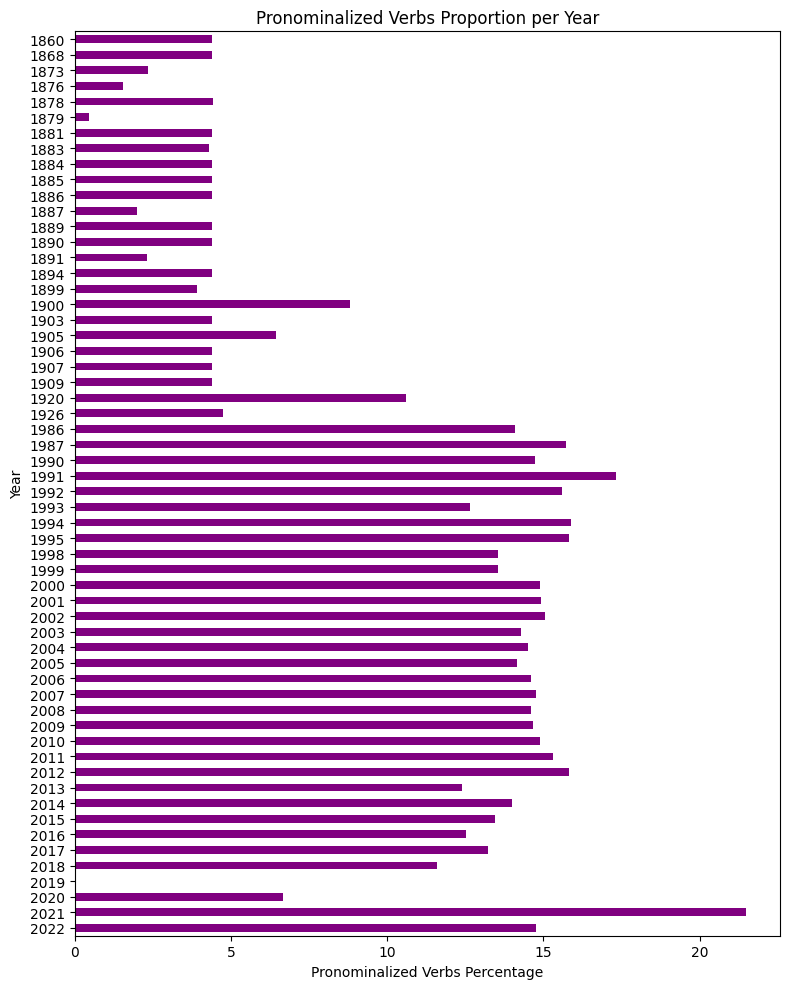

In [222]:
# grouping by year
# getting mean percentage of hi per text per year
df_grouped = current_df.groupby("Year")["PronV_percent"].mean()

plt.figure(figsize=(8, 10))
df_grouped.plot(kind="barh", color="purple")
plt.xlabel("Pronominalized Verbs Percentage")
plt.ylabel("Year")
plt.title("Pronominalized Verbs Proportion per Year")
plt.gca().invert_yaxis()  # Opcional, per invertir l'ordre de les etiquetes
plt.tight_layout()
plt.show()


In [223]:
# correlation year-verb pronominalization
rho_pstp, p_pstp = spearmanr(current_df["Year"], current_df["PronV_percent"])
print(f"Pronominalized Verbs% - rho: {rho_pstp:.4f}, p-value: {p_pstp:.4f}")

Pronominalized Verbs% - rho: 0.0137, p-value: 0.0000


In [224]:
# saving the data
current_df.to_pickle("complete_df.pkl")

## 4. Low-Level Analysis Conclusion and Findings